# Projeto de Redes Neurais Profundas – Treinamento
Este notebook realiza o treinamento da rede binária Wide ResNet com visualização das curvas de aprendizado.

In [1]:
# Instalação de dependências
!pip install albumentations --quiet

In [2]:
# Clonar o repositório com o código do projeto
import sys
import os
repo_dir = 'projeto-5-redes-profundas-projeto-v-produtos-industriais'
if not os.path.exists(repo_dir):
    !git clone --branch entrega-2 https://github.com/ICEI-PUC-Minas-PPL-CDIA/projeto-5-redes-profundas-projeto-v-produtos-industriais.git
%cd {repo_dir}
sys.path.append(f"/content/{repo_dir}")


Cloning into 'projeto-5-redes-profundas-projeto-v-produtos-industriais'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 311 (delta 31), reused 39 (delta 18), pack-reused 241 (from 1)
Receiving objects: 100% (311/311), 10.59 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/projeto-5-redes-profundas-projeto-v-produtos-industriais


In [3]:
# Montar o Google Drive para acessar os dados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git pull

Already up to date.


## Imports principais

Nesta célula são importadas as bibliotecas fundamentais para o treinamento da rede neural:

- `torch`, `nn` e `optim`: componentes do PyTorch usados para definir o modelo, a função de perda e o otimizador.
- `matplotlib.pyplot`: utilizado para gerar gráficos como as curvas de loss e acurácia ao longo do treinamento.
- `WRN_McDonnell`: a arquitetura da rede neural binária baseada na Wide Residual Network modificada, implementada de acordo com o artigo **"Training Wide Residual Networks for Deployment Using a Single Bit for Each Weight"** (McDonnell, ICLR 2018).


In [5]:
# Imports principais
import math
import copy
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
# Rede
from src.bynary_wide_resnet.wrn_mcdonnell import WRN_McDonnell
#Funções para a avaliação do modelo
from sklearn.metrics import f1_score, accuracy_score
#Funções criadas
from src.utils.load_data import load_image_paths_and_labels
from src.utils.split_data import split_dataset
from src.utils.transform import AlbumentationsTransform
from src.utils.dataset import CableDataset


## Preparação dos DataLoaders

Esta célula define a função `get_dataloaders()`, responsável por preparar os conjuntos de dados de treino e teste. Ela executa as seguintes etapas:

1. **Carregamento das imagens e rótulos**
   - A função `load_image_paths_and_labels()` percorre os diretórios da base de dados e associa cada imagem a uma classe.

2. **Divisão entre treino e teste**
   - A divisão estratificada é feita por `split_dataset()`, mantendo a proporção de cada classe nos dois conjuntos.

3. **Aplicação de transformações**
   - No modo `train`, são aplicadas transformações como rotação, brilho e flip para aumentar a robustez do modelo.
   - No modo `test`, apenas redimensionamento e normalização são aplicados.

4. **Criação dos objetos Dataset e DataLoader**
   - `CableDataset` representa um conjunto de imagens com seus rótulos.
   - `DataLoader` empacota os dados em lotes (`batch_size`) e gerencia a iteração durante o treino e teste.

> Essa função retorna dois objetos: `train_loader` e `test_loader`, prontos para serem usados no treinamento e validação do modelo.


In [6]:
def get_dataloaders(batch_size=8, test_size=0.2, num_workers=2, return_both=False):
    """
    Prepara os DataLoaders para treino e teste a partir da base de imagens.

    Parâmetros:
    - batch_size: número de amostras por batch.
    - test_size: proporção de dados reservados para o conjunto de teste.
    - num_workers: número de subprocessos para carregamento dos dados.
    - return_both: se True, retorna também a versão original da imagem no Dataset (útil para visualização).

    Retorna:
    - train_loader: DataLoader do conjunto de treino.
    - test_loader: DataLoader do conjunto de teste.
    - idx_to_class: dicionário com o mapeamento índice → nome da classe.
    """
    # Caminho base da base de dados
    root_dir = '/content/drive/MyDrive/Projeto-V/data/balanced cable'

    # Carrega os caminhos das imagens e seus rótulos
    image_paths, labels, class_to_idx = load_image_paths_and_labels(root_dir)

    # Mapeamento reverso para visualização
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Divide em treino e teste de forma estratificada
    (train_paths, train_labels), (test_paths, test_labels) = split_dataset(
        image_paths, labels, test_size=test_size
    )

    # Datasets
    train_dataset = CableDataset(
        train_paths,
        train_labels,
        transform=AlbumentationsTransform(mode="train"),
        return_both=return_both
    )
    test_dataset = CableDataset(
        test_paths,
        test_labels,
        transform=AlbumentationsTransform(mode="test"),
        return_both=return_both
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader, idx_to_class



### Carregamento dos Dados e Visualização de um Batch

Nesta célula, carregamos os dados com a função `get_dataloaders()` e visualizamos um batch de imagens para verificar se o carregamento e a associação de rótulos foram feitos corretamente.



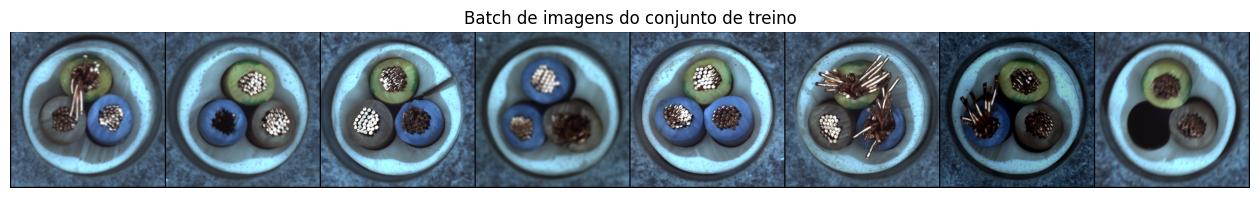

In [7]:
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=False)
    plt.figure(figsize=(16, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Batch de imagens do conjunto de treino")
    plt.axis('off')
    plt.show()

train_loader, test_loader, _ = get_dataloaders(return_both=False)
show_batch(train_loader)



> Agora iremos vizualizar as imagens ANTES e DEPOIS das transformações

In [18]:
def show_batch_original_transform(originais, transformadas, labels):
    """
    Exibe um batch de imagens com seus respectivos rótulos.

    Parâmetros:
    - imgs: Tensor de imagens com shape [batch_size, C, H, W]
    - labels: Tensor de rótulos com shape [batch_size]

    O PyTorch trabalha com imagens no formato [C, H, W],
    mas o matplotlib espera [H, W, C].
    Por isso, fazemos o permute.
    """
    def prepare_for_display(tensor):
        # Converte imagens uint8 [0,255] → float32 [0,1] apenas se necessário
        if tensor.dtype != torch.float32:
            tensor = tensor.float() / 255.0
        return tensor.clamp(0, 1)

    batch_size = len(labels)
    total_imgs = batch_size * 2  # original + transformada para cada item

    def get_subplot_grid(n):
        """Retorna (nrows, ncols) para n subplots com layout mais retangular possível."""
        ncols = math.floor(math.sqrt(n))
        nrows = math.ceil(n / ncols)
        return nrows, ncols

    nrows, ncols = get_subplot_grid(total_imgs)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    ax = ax.flatten()

    for i in range(batch_size):
        # Imagem original
        img_o = prepare_for_display(originais[i]).permute(1, 2, 0).cpu().numpy()
        ax[2 * i].imshow(img_o)
        ax[2 * i].set_title(f"Original - Label: {labels[i].item()}")
        ax[2 * i].axis('off')

        # Imagem transformada
        img_t = prepare_for_display(transformadas[i]).permute(1, 2, 0).cpu().numpy()
        ax[2 * i + 1].imshow(img_t)
        ax[2 * i + 1].set_title("Transformada")
        ax[2 * i + 1].axis('off')

    for j in range(2 * batch_size, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()
    plt.show()

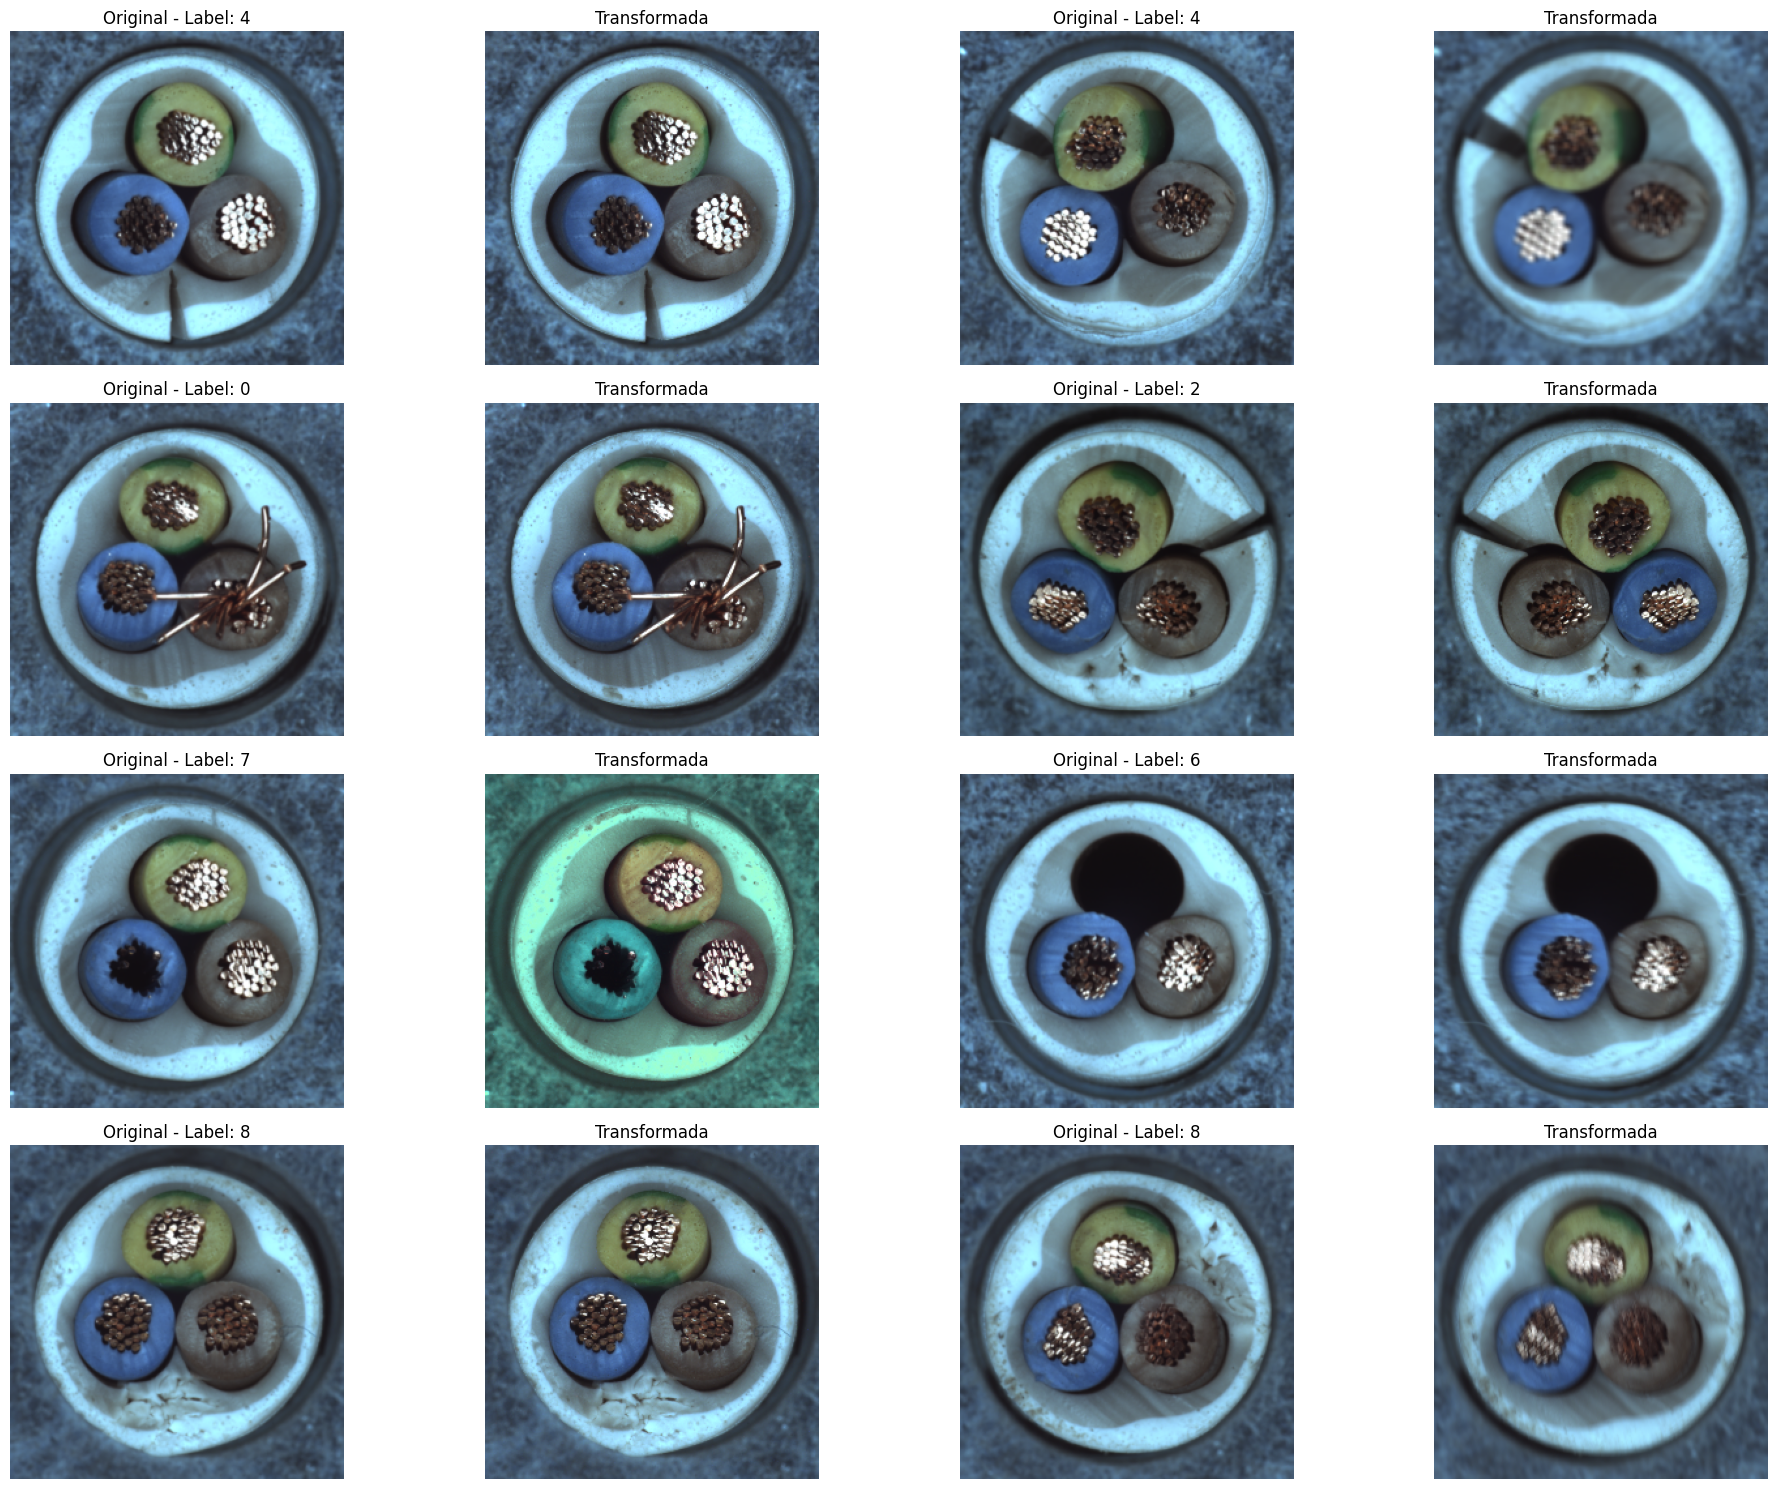

In [19]:
train_loader_debug, _, idx_to_class = get_dataloaders(batch_size=8, return_both=True)
original, trandform, labels = next(iter(train_loader_debug))
show_batch_original_transform(original, trandform, labels)

In [24]:
#Verificando Distribuição das classes
from collections import Counter

# Reextração dos rótulos dos datasets
train_labels = [label for _, label in train_loader.dataset]
test_labels = [label for _, label in test_loader.dataset]

print("Distribuição das classes no TREINO:")
print(Counter(train_labels))

print("\nDistribuição das classes no TESTE:")
print(Counter(test_labels))


Distribuição das classes no TREINO:
Counter({3: 11, 5: 10, 6: 10, 0: 10, 2: 9, 1: 9, 8: 8, 4: 8, 7: 8})

Distribuição das classes no TESTE:
Counter({1: 3, 3: 3, 0: 3, 7: 2, 8: 2, 5: 2, 4: 2, 2: 2, 6: 2})


## Configurações de treinamento

Nesta célula são definidos os principais parâmetros que controlam o treinamento da rede, assim como o dispositivo (CPU ou GPU) que será utilizado.

- `DEVICE`: Define se o modelo será treinado em GPU (`cuda`) ou CPU, dependendo da disponibilidade. O uso de GPU acelera significativamente o treinamento, especialmente em modelos com grande volume de dados ou profundidade.
  
- `NUM_CLASSES`: Define o número de classes presentes no conjunto de dados. Este valor deve ser igual ao número de categorias diferentes que o modelo deve aprender a classificar. No caso atual, estamos utilizando **9 classes**.

- `EPOCHS`: Número de épocas (passagens completas pelo conjunto de treinamento). Um valor mais alto permite que o modelo aprenda melhor, mas também aumenta o tempo de execução. É necessário monitorar o desempenho para evitar overfitting.

- `LR` (Learning Rate): Taxa de aprendizado do otimizador. Este hiperparâmetro controla o tamanho dos ajustes feitos nos pesos da rede durante o treinamento. Valores muito altos podem causar instabilidade, enquanto valores muito baixos podem tornar o aprendizado lento.

- `BATCH_SIZE`: Quantidade de amostras utilizadas em cada iteração do treinamento. Um valor maior aumenta o uso de memória, mas pode melhorar a estabilidade do gradiente. Neste caso, usamos 64 imagens por batch.

Essas configurações são utilizadas ao longo do notebook para inicializar o modelo, definir o otimizador e estruturar o loop de treinamento.


In [17]:
# Configurações de treino
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 9
EPOCHS = 200
LR = 0.01
BATCH_SIZE = 32

## Inicialização do modelo, função de perda, otimizador e dataloaders

Esta célula prepara todos os componentes necessários para iniciar o processo de treinamento da rede neural.




In [12]:
# Inicializar modelo, dataloaders e otimizador
model = WRN_McDonnell(
    depth=22,
    width=4,
    num_classes=NUM_CLASSES,
    binarize=True
    ).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=LR,
    momentum=0.9,
    weight_decay=1e-4
    )

train_loader, test_loader, _= get_dataloaders(batch_size=BATCH_SIZE)

## Funções auxiliares para treino e validação

Estas funções encapsulam a lógica principal das fases de **treinamento** e **validação** da rede, permitindo uma estrutura de código mais clara, reutilizável e modular.

### `train_one_epoch`

Executa **uma época completa de treinamento** sobre os dados de treino.  
Passo a passo do que ocorre dentro da função:
1. `model.train()`: Coloca o modelo em modo de treinamento, ativando camadas como dropout e batch normalization.
2. Para cada batch do `dataloader`:
   - Move as imagens (`x`) e os rótulos (`y`) para o dispositivo de execução (GPU/CPU).
   - Zera os gradientes acumulados com `optimizer.zero_grad()`.
   - Faz a inferência com `model(x)` e calcula a perda com a `criterion`.
   - Executa `loss.backward()` para computar os gradientes via backpropagation.
   - Atualiza os pesos com `optimizer.step()`.
   - Acumula a perda total e o número de acertos.
3. Retorna:
   - **Perda média** da época (`total_loss / len(dataloader)`).
   - **Acurácia (%)**: percentual de previsões corretas.

### `evaluate`

Realiza a **avaliação do modelo** sobre o conjunto de validação/teste, **sem alterar os pesos**:
1. `model.eval()`: Coloca o modelo em modo de avaliação, desativando dropout e congelando batch normalization.
2. Envolve a execução em `with torch.no_grad()` para evitar o cálculo e o armazenamento de gradientes, economizando memória.
3. Para cada batch:
   - Move os dados para o dispositivo.
   - Faz a inferência e calcula a perda.
   - Acumula os acertos e o total de amostras.
4. Retorna:
   - **Perda média** da avaliação.
   - **Acurácia (%)** da predição sobre o conjunto de validação/teste.

---

Essas duas funções serão usadas no loop de épocas para medir o desempenho do modelo em cada etapa do treinamento.


In [13]:
# Funções auxiliares para treino e validação
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(dataloader), 100 * correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100  # macro = média entre classes

    return avg_loss, acc, f1

## Loop de treinamento

Nesta etapa, o modelo é treinado por várias épocas (definidas anteriormente pela variável `EPOCHS`).  
Durante cada época, executamos uma rodada de treino e uma de validação, registrando as métricas principais para análise posterior.

### Variáveis de acompanhamento

São criadas quatro listas para armazenar o histórico de métricas ao longo das épocas:
- `train_losses`: perdas (loss) no conjunto de treino por época.
- `test_losses`: perdas no conjunto de validação por época.
- `train_accs`: acurácias no conjunto de treino por época.
- `test_accs`: acurácias no conjunto de validação por época.
- `test_f1s`: F1 scores no conjunto de validação por época.

### Laço de épocas

Para cada época:
1. **Treinamento**: `train_one_epoch(...)`
   - Calcula a perda e acurácia no conjunto de treino.
   - Atualiza os pesos da rede.
2. **Validação**: `evaluate(...)`
   - Mede a performance da rede sobre dados **não vistos** (sem alterar pesos).
3. Os resultados são armazenados nas listas para análise posterior.
4. Um `print` resume os resultados da época, com:
   - `Loss={tloss:.4f}/{vloss:.4f}`: perda de treino e validação.
   - `Acc={tacc:.2f}%/{vacc:.2f}%`: acurácia de treino e validação.




In [14]:
# Loop de treino
# Variáveis de rastreamento
melhor_f1 = -1
melhor_estado = None

train_losses, test_losses = [], []
train_accs, test_accs = [], []
test_f1s = []

for epoch in range(EPOCHS):
    tloss, tacc = train_one_epoch(model, train_loader, criterion, optimizer)
    vloss, vacc, vf1 = evaluate(model, test_loader, criterion)

    train_losses.append(tloss)
    test_losses.append(vloss)
    train_accs.append(tacc)
    test_accs.append(vacc)
    test_f1s.append(vf1)

    # Se o F1 melhorou, salva o modelo atual
    if vf1 > melhor_f1:
        melhor_f1 = vf1
        melhor_estado = copy.deepcopy(model.state_dict())

    print(f"Época {epoch+1}: Loss={tloss:.4f}/{vloss:.4f}, "
          f"Acc={tacc:.2f}%/{vacc:.2f}%, F1={vf1:.2f}%")

# Após o treinamento, carrega o melhor modelo
model.load_state_dict(melhor_estado)


Época 1: Loss=2.1711/2.2452, Acc=16.87%/9.52%, F1=1.93%
Época 2: Loss=2.1396/2.2561, Acc=24.10%/9.52%, F1=1.93%
Época 3: Loss=2.0644/2.2506, Acc=37.35%/9.52%, F1=1.93%
Época 4: Loss=2.0567/2.2616, Acc=43.37%/9.52%, F1=2.12%
Época 5: Loss=2.0140/2.2857, Acc=46.99%/9.52%, F1=2.22%
Época 6: Loss=2.0246/2.3204, Acc=46.99%/9.52%, F1=1.93%
Época 7: Loss=1.9878/2.3025, Acc=51.81%/9.52%, F1=2.34%
Época 8: Loss=1.9790/2.2577, Acc=54.22%/4.76%, F1=1.31%
Época 9: Loss=1.9499/2.2408, Acc=55.42%/9.52%, F1=1.93%
Época 10: Loss=1.9236/2.2204, Acc=60.24%/9.52%, F1=1.93%
Época 11: Loss=1.9133/2.2313, Acc=57.83%/9.52%, F1=2.02%
Época 12: Loss=1.8954/2.2618, Acc=55.42%/9.52%, F1=2.02%
Época 13: Loss=1.8650/2.2314, Acc=57.83%/4.76%, F1=2.22%
Época 14: Loss=1.8734/2.2413, Acc=53.01%/9.52%, F1=1.93%
Época 15: Loss=1.8152/2.2319, Acc=62.65%/9.52%, F1=1.93%
Época 16: Loss=1.7785/2.2739, Acc=63.86%/9.52%, F1=1.93%
Época 17: Loss=1.8276/2.2191, Acc=54.22%/23.81%, F1=8.47%
Época 18: Loss=1.7969/2.1589, Acc=61.45

<All keys matched successfully>

In [15]:
def plot_metricas_treinamento(train_losses, test_losses, train_accs, test_accs, test_f1s=None):
    epocas = range(1, len(train_losses) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epocas, train_losses, label="Treino")
    plt.plot(epocas, test_losses, label="Validação")
    plt.title("Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    # Acurácia
    plt.subplot(1, 3, 2)
    plt.plot(epocas, train_accs, label="Treino")
    plt.plot(epocas, test_accs, label="Validação")
    plt.title("Acurácia")
    plt.xlabel("Época")
    plt.ylabel("Acurácia (%)")
    plt.legend()

    # F1-score (se disponível)
    if test_f1s is not None:
        plt.subplot(1, 3, 3)
        plt.plot(epocas, test_f1s, label="Validação", color='purple')
        plt.title("F1-score")
        plt.xlabel("Época")
        plt.ylabel("F1 (%)")
        plt.legend()

    plt.tight_layout()
    plt.show()


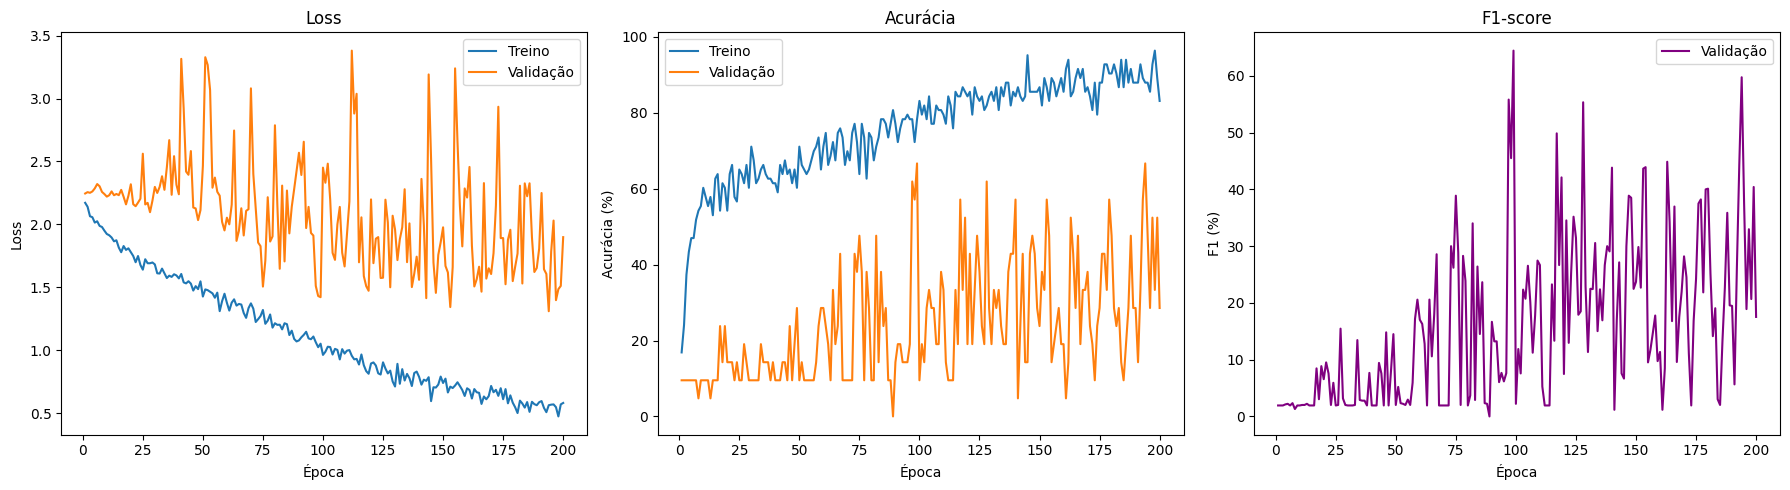

In [25]:
plot_metricas_treinamento(train_losses, test_losses, train_accs, test_accs, test_f1s)

In [26]:
# Carrega o modelo com melhor F1
model.load_state_dict(melhor_estado)


<All keys matched successfully>

In [27]:
torch.save(melhor_estado, 'melhor_modelo.pth')


In [28]:
melhor_estado = torch.load('melhor_modelo.pth')
model.load_state_dict(melhor_estado)


<All keys matched successfully>

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import numpy as np
import torch.nn.functional as F

model.eval()  # Coloca o modelo em modo de avaliação

todos_rotulos = []
todas_predicoes = []

with torch.no_grad():
    for imagens, rotulos in test_loader:
        imagens, rotulos = imagens.to(DEVICE), rotulos.to(DEVICE)
        saidas = model(imagens)
        probs = F.softmax(saidas, dim=1)
        predicoes = torch.argmax(probs, dim=1)

        todos_rotulos.extend(rotulos.cpu().numpy())
        todas_predicoes.extend(predicoes.cpu().numpy())

# Conversão final para arrays
y_true = np.array(todos_rotulos)
y_pred = np.array(todas_predicoes)

# Relatório detalhado
print("=== Relatório de Classificação ===")
print(classification_report(y_true, y_pred, digits=4))

# Métricas principais
acc = accuracy_score(y_true, y_pred) * 100
f1_macro = f1_score(y_true, y_pred, average='macro') * 100

print(f"Acurácia final: {acc:.2f}%")
print(f"F1-score macro: {f1_macro:.2f}%")

# Matriz de confusão
print("=== Matriz de Confusão ===")
print(confusion_matrix(y_true, y_pred))


=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0     0.4286    1.0000    0.6000         3
           1     0.6667    0.6667    0.6667         3
           2     0.3333    0.5000    0.4000         2
           3     1.0000    0.6667    0.8000         3
           4     1.0000    0.5000    0.6667         2
           5     0.0000    0.0000    0.0000         2
           6     1.0000    1.0000    1.0000         2
           7     1.0000    0.5000    0.6667         2
           8     1.0000    1.0000    1.0000         2

    accuracy                         0.6667        21
   macro avg     0.7143    0.6481    0.6444        21
weighted avg     0.7120    0.6667    0.6508        21

Acurácia final: 66.67%
F1-score macro: 64.44%
=== Matriz de Confusão ===
[[3 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 0 0 2 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Localiza o índice do maior F1 no vetor
melhor_epoca = np.argmax(test_f1s)
melhor_f1 = test_f1s[melhor_epoca]

print(f"Melhor F1-score: {melhor_f1:.2f}% na época {melhor_epoca + 1}")


Melhor F1-score: 64.44% na época 99
